In [1]:
import glob
import os.path as osp
import pickle
import random
import numpy as np
import json
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import models, transforms
import matplotlib.pyplot as plt

import datasets.dataset as dataset
from datasets.load_adni import load_adni2
import models.models as models
from utils.data_class import BrainDataset
import torchio as tio
from tqdm import tqdm
#from models.models import Vgg16, FujiNet1

/home/balt/medical-team-onboarding2024/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# dataloader作成時にラベル情報を数値に変換するために使用するdict型変数
CLASS_MAP = {
    "CN": 0,
    "AD": 1,
}
# 再現性を保つために設定しておく値
SEED_VALUE = 0

In [3]:
# seed値を設定（random, Numpy, PyTorch）
def fix_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.benchmark = (
        False  # この行をFalseにすると再現性はとれるが、速度が落ちる
    )
    torch.backends.cudnn.deterministic = True
    return

fix_seed(0)

In [4]:
# 脳MRIの画像を読み込み（今回は"CN", "AD"のみ）
dataset = load_adni2(classes=["CN", "AD"],size="half", unique=True, mni=False, strength=["3.0"])

# datasetの枚数を表示
len(dataset)

100%|██████████| 571/571 [00:32<00:00, 17.52it/s]


571

In [5]:
# datasetの1枚の情報を見てみる
dataset[0]

{'pid': '098_S_4003',
 'sex': 'F',
 'age': '72.4137',
 'weight': '56.7',
 'day': '2011-03-22',
 'uid': '225425',
 'preprocessing': 'MT1; GradWarp; N3m',
 'slice_thickness': '1.2',
 'plane': 'SAGITTAL',
 'x': '1.0156',
 'y': '1.0156',
 'manufacturer': 'GE MEDICAL SYSTEMS',
 'model': 'DISCOVERY MR750',
 'strength': '3.0',
 'class': 'CN',
 'mmse': '30.0',
 'moca': '24.0',
 'class_base': 'CN',
 'mmse_base': '30.0',
 'moca_base': '24.0',
 'path_full': '/data2/radiology_datas/clean3/ADNI2/full/rigid/225425.nii',
 'path_half': '/data2/radiology_datas/clean3/ADNI2/half/rigid/225425.nii',
 'path_full_mni': '/data2/radiology_datas/clean3/ADNI2/full/trsaa/225425.nii',
 'path_half_mni': '/data2/radiology_datas/clean3/ADNI2/half/trsaa/225425.nii',
 'voxel': memmap([[[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ...

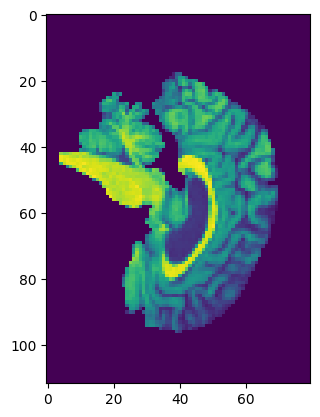

In [6]:
# datasetの画像を1枚見てみる
%matplotlib inline
plt.imshow(dataset[0]["voxel"][40,:,:])

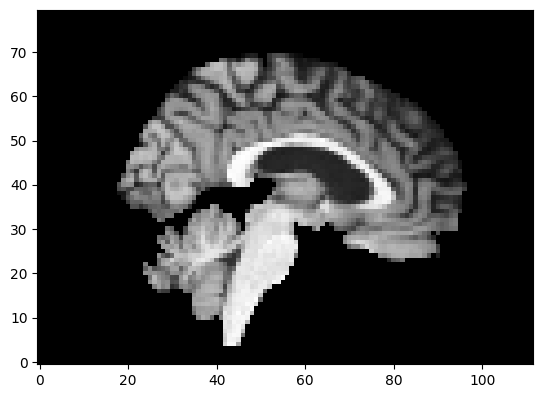

In [7]:
# datasetの画像を1枚見てみる
%matplotlib inline
plt.imshow(dataset[0]["voxel"][40,:,:].T, origin="lower", cmap="gray")

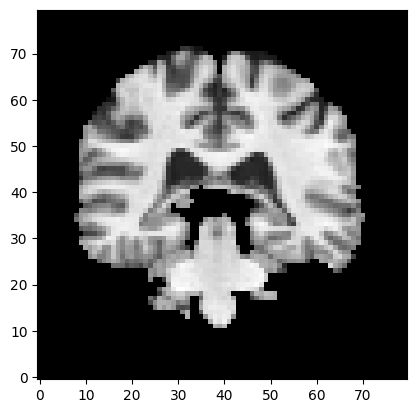

In [8]:
# datasetの画像を1枚見てみる
%matplotlib inline
plt.imshow(dataset[0]["voxel"][:,48,:].T, origin="lower", cmap="gray")

In [9]:
# datasetの」中から使用する情報をそれぞれ取ってくる
pids = []
voxels = np.zeros((len(dataset), 80, 112, 80))
labels = np.zeros(len(dataset))
for i in tqdm(range(len(dataset))):
    pids.append(dataset[i]["pid"])
    voxels[i] = dataset[i]["voxel"]
    # voxels[i] = normalize(voxels[i], np.min(voxels[i]), np.max(voxels[i]))
    labels[i] = CLASS_MAP[dataset[i]["class"]]
pids = np.array(pids)

100%|██████████| 571/571 [00:02<00:00, 218.60it/s]


In [10]:
# trainとtest用の画像を、同じ患者が分かれて入らないように分ける。

from sklearn.model_selection import StratifiedGroupKFold, train_test_split

# train_datadict, val_datadict = train_test_split(dataset, test_size=0.2, shuffle=True, random_state=SEED_VALUE)

pids = []
for i in range(len(dataset)):
    pids.append(dataset[i]["pid"])
gss = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=SEED_VALUE)
train_idx, val_idx = list(gss.split(voxels,labels, groups=pids))[0]
train_voxels = voxels[train_idx]
val_voxels = voxels[val_idx]
train_labels = labels[train_idx]
val_labels = labels[val_idx]

len(train_voxels)

456

In [11]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    
g = torch.Generator()
g.manual_seed(0)

In [12]:
# train/val dataset を作成
train_set = BrainDataset(train_voxels, train_labels)
val_set = BrainDataset(val_voxels, val_labels)

print("size of the training dataset = ", len(train_set))
print("size of the validation dataset = ", len(val_set))
print("training image shape = {}, training label = {}".format(train_set(0)[0].shape, train_set(0)[1]))
print("test image shape = {}, test label = {}".format(val_set(0)[0].shape, val_set(0)[1]))

size of the training dataset =  456
size of the validation dataset =  115
training image shape = (1, 80, 112, 80), training label = 0.0
test image shape = (1, 80, 112, 80), test label = 0.0


In [13]:
# Function line up input images and output images
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error


def show_image(image):    
    %matplotlib inline

    fig = plt.figure(figsize=(18,5),dpi=600)
    X, Y = 1, 6
    
    for i in range(6):
        imgplot = i + 1
        ax1 = fig.add_subplot(X, Y, imgplot)
        print(f"type={image.dtype}")
        img = np.flip(image.reshape(80, 112, 80).transpose(1,2,0)[50+i],0)
        plt.axis("off")
        plt.imshow(img,cmap="gray")
        plt.tick_params(labelsize=8)
        
    plt.show()

type=float32
type=float32
type=float32
type=float32
type=float32
type=float32


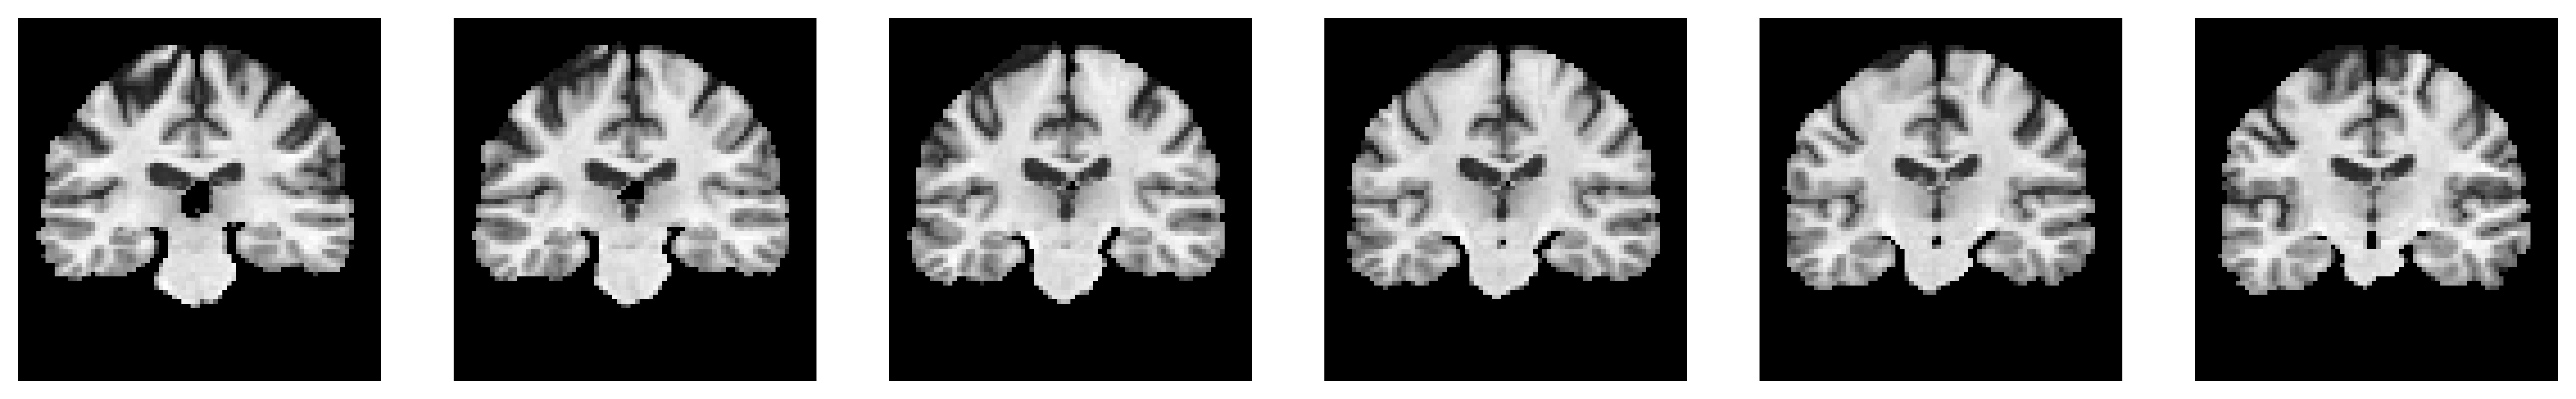

In [14]:
idx = 20
image, label = train_set(idx)

show_image(image)

mean= 0.13431239
max=1.0 min=0.0
0.0


/tmp/ipykernel_2731009/589869620.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


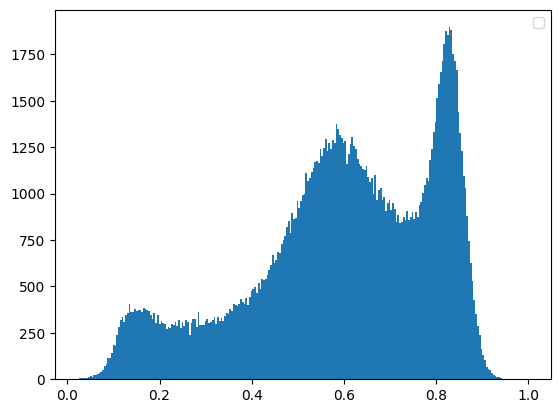

In [15]:
# 画像１枚あたりの輝度値ヒストグラム
print("mean=", image.mean())
print(f"max={image.max()} min={image.min()}")
print(label)
#imge = np.clip(image, 0, None)
show_img = image.reshape(80*112*80)
plt.hist(show_img[show_img > 0.01], bins=255)
#plt.title("Accuracy")
#plt.xlabel("Epoch")
#plt.ylabel("Accuracy")
plt.legend()

571


(array([1.02000e+02, 2.71000e+02, 5.02000e+02, 8.44000e+02, 1.39800e+03,
        2.05400e+03, 2.87700e+03, 3.66600e+03, 4.71100e+03, 6.06900e+03,
        7.46600e+03, 9.24900e+03, 1.14480e+04, 1.41570e+04, 1.69070e+04,
        2.01130e+04, 2.43240e+04, 2.88540e+04, 3.41290e+04, 4.04420e+04,
        4.70330e+04, 5.42280e+04, 6.24160e+04, 7.05740e+04, 7.93940e+04,
        8.94480e+04, 9.89030e+04, 1.08930e+05, 1.19000e+05, 1.29422e+05,
        1.39804e+05, 1.51134e+05, 1.61218e+05, 1.71952e+05, 1.83945e+05,
        1.94296e+05, 2.06093e+05, 2.14392e+05, 2.22193e+05, 2.29637e+05,
        2.35215e+05, 2.38163e+05, 2.39691e+05, 2.39949e+05, 2.38516e+05,
        2.36014e+05, 2.32964e+05, 2.30292e+05, 2.25899e+05, 2.23759e+05,
        2.19174e+05, 2.16044e+05, 2.12820e+05, 2.10655e+05, 2.06574e+05,
        2.04247e+05, 2.00943e+05, 1.98417e+05, 1.95716e+05, 1.92573e+05,
        1.91269e+05, 1.90242e+05, 1.87203e+05, 1.87179e+05, 1.85957e+05,
        1.85255e+05, 1.85051e+05, 1.84688e+05, 1.84

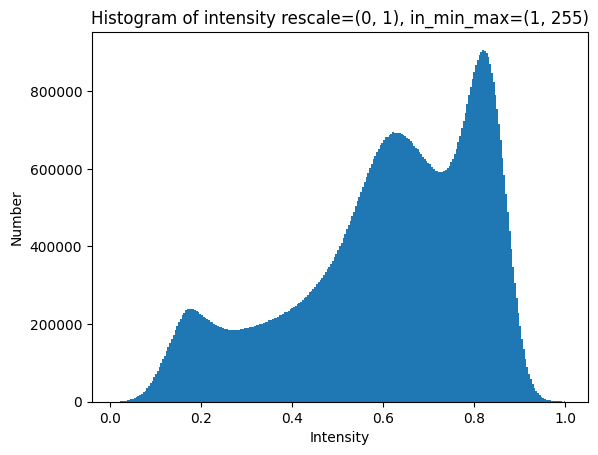

In [16]:
image_list = []
max = 0.01
for image, label in train_set:
    if max < image.max():
        max = image.max()
    image_reshape = image.reshape(80*112*80)
    image_list.append(image_reshape)

for image, label in val_set:
    if max < image.max():
        max = image.max()
    image_reshape = image.reshape(80*112*80)
    image_list.append(image_reshape)
print(len(image_list))

imagelist = np.concatenate(image_list)
plt.title("Histogram of intensity rescale=(0, 1), in_min_max=(1, 255)")
plt.xlabel("Intensity")
plt.ylabel("Number")
plt.hist(imagelist[imagelist > 0.01], bins=255)

In [17]:
print(max)

1.0


In [18]:
train_dataloader = DataLoader(train_set, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size=16, shuffle=False)

In [19]:
net = models.VAE3D()
print(net)

VAE3D(
  (encoder): Sequential(
    (0): Conv3d(1, 3, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): ReLU()
    (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv3d(3, 3, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (4): ReLU()
    (5): Conv3d(3, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (6): ReLU()
    (7): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (9): ReLU()
    (10): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (11): ReLU()
    (12): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=89600, out_features=512, bias=True)
  (fc_mu): Linear(in_features=512, out_features=256, bias=True)
  (fc_logvar): Linear(in_features=512, out_features=256, bias=True)
  (defc1): Linear(

In [20]:
def vae_loss_function(recon_x, x, mu, logvar):
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')  
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss

In [21]:
optimizer = optim.Adam(params=net.parameters(), lr=0.001)

In [22]:
def train_model(net, train_dataloader, val_dataloader, optimizer, num_epochs, log_path="./log/3DVAE/"):
    import os
    os.makedirs(log_path, exist_ok=True)

    device = torch.device("cuda:5" if torch.cuda.is_available() else "cpu")
    net.to(device)
    print("Use device =", device)
    
    train_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        # ====== train ======
        net.train()
        train_loss = 0.0

        for inputs, _ in train_dataloader:
            inputs = inputs.to(device=device, dtype=torch.float32)

            optimizer.zero_grad()

            recon_x, mu, logvar = net(inputs)
            loss = vae_loss_function(recon_x, inputs, mu, logvar)

            loss.backward()
            optimizer.step()

            train_loss += loss.item() / len(train_dataloader)

        train_losses.append(train_loss)

        # ====== validation ======
        net.eval()
        test_loss = 0.0

        with torch.no_grad():
            for inputs, _ in val_dataloader:
                inputs = inputs.to(device=device, dtype=torch.float32)

                recon_x, mu, logvar = net(inputs)
                loss = vae_loss_function(recon_x, inputs, mu, logvar)

                test_loss += loss.item() / len(val_dataloader)

        test_losses.append(test_loss)

        print(f"EPOCH {epoch+1} || train loss: {train_loss:.4f}, val loss: {test_loss:.4f}")

    # モデル保存
    torch.save(net.state_dict(), os.path.join(log_path, f"3DVAE_{epoch+1}.pth"))


    import matplotlib.pyplot as plt

    # Lossグラフ作成
    plt.figure(figsize=(8,6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(log_path, 'loss_curve.png'))  # 画像保存
    plt.show()


Use device = cuda:5
EPOCH 1 || train loss: 982093.6665, val loss: 593835.5781
EPOCH 2 || train loss: 352658.1730, val loss: 250191.5708
EPOCH 3 || train loss: 227211.1805, val loss: 260936.6294
EPOCH 4 || train loss: 190935.3085, val loss: 160932.0977
EPOCH 5 || train loss: 175362.7468, val loss: 175853.7319
EPOCH 6 || train loss: 161447.5706, val loss: 140069.9260
EPOCH 7 || train loss: 153586.5577, val loss: 135034.2598
EPOCH 8 || train loss: 148430.3171, val loss: 141498.8401
EPOCH 9 || train loss: 144297.7078, val loss: 132781.8445
EPOCH 10 || train loss: 143885.8006, val loss: 154791.2910
EPOCH 11 || train loss: 142378.6980, val loss: 129783.7004
EPOCH 12 || train loss: 137234.3561, val loss: 128846.2544
EPOCH 13 || train loss: 133253.7241, val loss: 121100.8623
EPOCH 14 || train loss: 130331.1382, val loss: 136753.6301
EPOCH 15 || train loss: 127179.1519, val loss: 113238.3625
EPOCH 16 || train loss: 124028.7815, val loss: 128532.8003
EPOCH 17 || train loss: 124569.3753, val loss

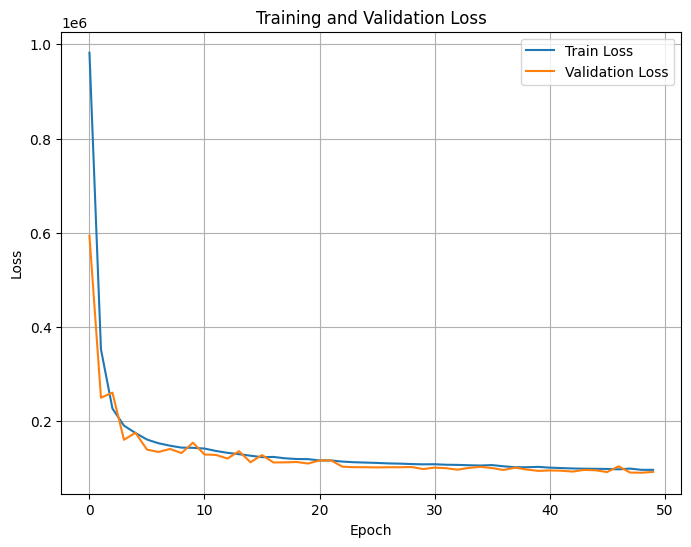

In [23]:
num_epochs = 50


train_model(net, train_dataloader, val_dataloader, optimizer, num_epochs)

In [48]:
import matplotlib.pyplot as plt
import torch

def plot_single_reconstructed(net, val_dataloader, device="cuda:5"):
    net.eval()  # 推論モードにする
    inputs, _ = next(iter(val_dataloader))  # valデータから1バッチ取り出し
    inputs = inputs.to(device=device, dtype=torch.float32)
    
    with torch.no_grad():
        outputs, mu, logvar = net(inputs)  # 再構成画像を生成

    # CPUに戻す
    input_img = inputs[0].cpu().numpy()
    output_img = outputs[0].cpu().numpy()

    # 3D画像なので、中央スライス（depth方向の真ん中）を取る
    mid_slice = input_img.shape[1] // 2  # D方向の中心スライス

    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    # Original
    axes[0].imshow(input_img[0, mid_slice, :, :].T,origin="lower",cmap="gray")
    axes[0].set_title("Original")
    axes[0].axis('off')

    # Reconstructed
    axes[1].imshow(output_img[0, mid_slice, :, :].T,origin="lower",cmap="gray")
    axes[1].set_title("Reconstructed")
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()


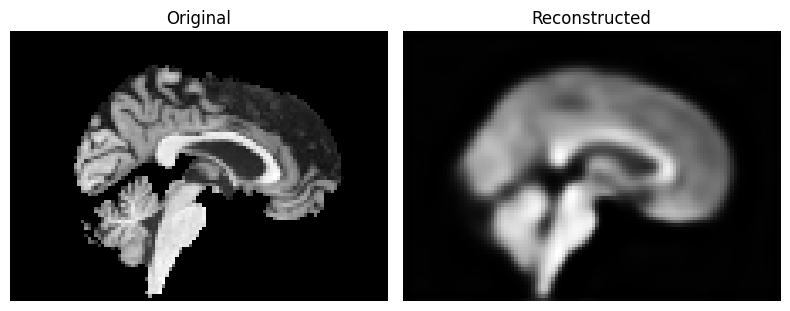

In [49]:
plot_single_reconstructed(net, val_dataloader, device="cuda:5")


In [58]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def plot_latent_space_tsne(net, dataloader, device="cuda:5"):
    net.eval()
    mus = []
    labels_list = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device=device, dtype=torch.float32)
            _, mu, _ = net(inputs)
            mus.append(mu.cpu())
            labels_list.append(labels)

    mus = torch.cat(mus, dim=0).numpy()
    labels_list = torch.cat(labels_list, dim=0).numpy()

    # t-SNEで次元圧縮
    tsne = TSNE(n_components=2, random_state=0, perplexity=30)
    mus_2d = tsne.fit_transform(mus)

    plt.figure(figsize=(8,6))
    plt.scatter(mus_2d[:, 0], mus_2d[:, 1], c=labels_list, cmap="tab10", alpha=0.7)
    plt.title("Latent Space (t-SNE)")
    plt.grid(True)
    plt.show()


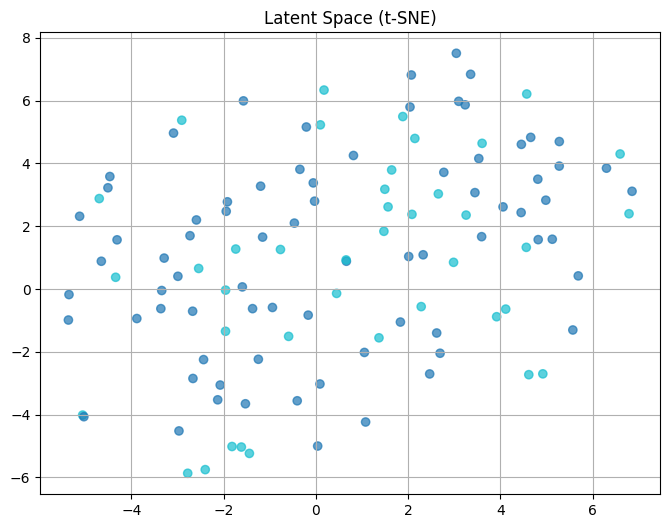

In [59]:
plot_latent_space_tsne(net, val_dataloader)

In [60]:
import umap.umap_ as umap

import matplotlib.pyplot as plt

def plot_latent_space_umap(net, dataloader, device="cuda:5"):
    net.eval()
    mus = []
    labels_list = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device=device, dtype=torch.float32)
            _, mu, _ = net(inputs)
            mus.append(mu.cpu())
            labels_list.append(labels)

    mus = torch.cat(mus, dim=0).numpy()
    labels_list = torch.cat(labels_list, dim=0).numpy()

    reducer = umap.UMAP(random_state=0)
    mus_2d = reducer.fit_transform(mus)

    plt.figure(figsize=(8,6))
    plt.scatter(mus_2d[:, 0], mus_2d[:, 1], c=labels_list, cmap="tab10", alpha=0.7)
    plt.title("Latent Space (UMAP)")
    plt.grid(True)
    plt.show()


/home/balt/medical-team-onboarding2024/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/balt/medical-team-onboarding2024/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


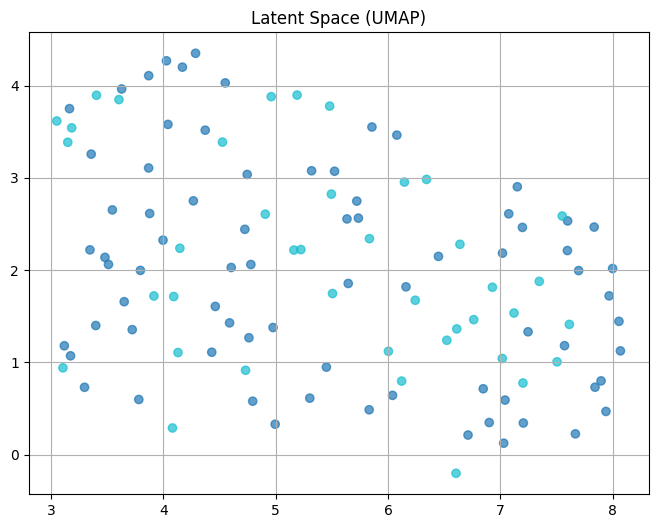

In [61]:
plot_latent_space_umap(net, val_dataloader)

In [54]:
import torch
import matplotlib.pyplot as plt

def sample_from_latent_sagittal(net, num_samples=5, device="cuda:5"):
    net.eval()
    z_dim = 256  # 潜在空間の次元
    z = torch.randn(num_samples, z_dim).to(device)

    with torch.no_grad():
        x = net.defc2(net.defc1(z))
        x = x.view(num_samples, 64, 10, 14, 10)
        recon_imgs = net.decoder_conv(x).cpu().numpy()

    # Plot sagittal slices
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 4))
    for i in range(num_samples):
        # sagittal: 横軸（width）方向の中央スライス
        sagittal_slice = recon_imgs[i, 0, recon_imgs.shape[4] // 2, :, :]
        axes[i].imshow(sagittal_slice.T, cmap="gray", origin="lower")
        axes[i].set_title(f"Sample {i+1}")
        axes[i].axis("off")

    plt.suptitle("Generated Sagittal Slices from Latent Space")
    plt.tight_layout()
    plt.show()


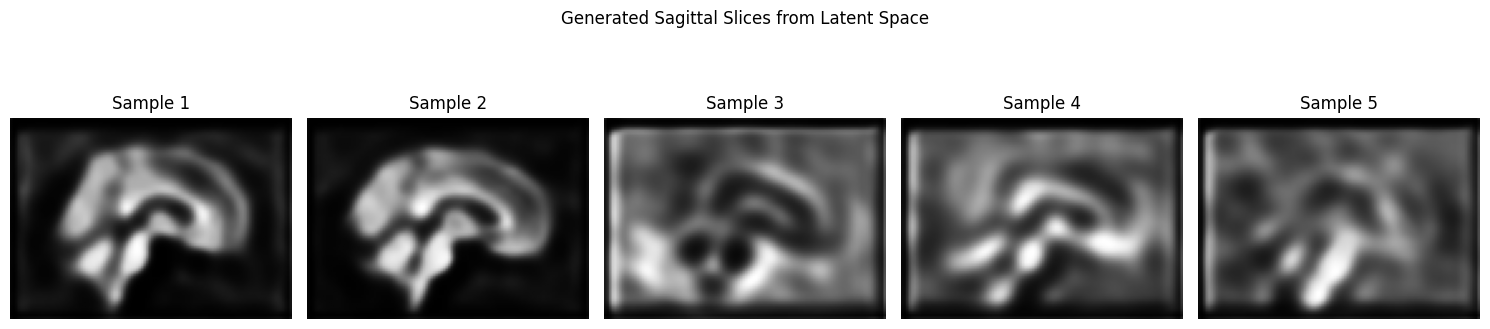

In [55]:
sample_from_latent_sagittal(net, num_samples=5, device="cuda:5")
